<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/CU-86bwcdr5f_Analiza-korelacji-rolinnoci-z-pozostaymi-zmiennymi_Piotr-Puchalski/colabs/Analiza_Korelacji_NASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W tym pliku zajmiemy się analizą korealcji między roślinnością, a innymi cechami zawartymi w naszych danych

In [ ]:
!pip install pyspark

In [ ]:

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType
spark = SparkSession.builder.appName('Corr_Analysis').getOrCreate()

Teraz zaimportujemy dane

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

sampled = pd.read_csv('/content/drive/MyDrive/BigMess/NASA/sampled_NASA_200k.csv')

schemat = StructType()
for i in sampled.columns:
  if i == "Date":
    schemat = schemat.add(i, StringType(), True)
  else:
    schemat = schemat.add(i, FloatType(), True)

nasa = spark.read.format('csv').option("header", True).schema(schemat).load('/content/drive/MyDrive/BigMess/NASA/NASA.csv')
nasa.show(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+---------+-------+------+---------+---------+---------+---------+---------+---------+----------+---+-----+-----+---------+---+----------+---+---------+---------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+----------+------------+-------------+--------------+---------------+---------------+---------------+---------+----------+---------+----------+-------+------------+-----------+------------+----------+----------+----------+----------+---------+------------+---------+----------+----------+
|      lon|    lat|  Date|   SWdown|   LWdown|    SWnet|    LWnet|      Qle|       Qh|        Qg| Qf|Snowf|Rainf|     Evap| Qs|       Qsb|Qsm| AvgSurfT|   Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10

Po wczytaniu danych usuniemy kolumny, które nie będą nam potrzebne przy analizie korelacji roślinności z pozostałymi zmiennymi


In [ ]:
# usuwamy z danych kolumny odpowiadające za długość i szerokość geograficzną oraz datę
columns_to_delete = ['lon', 'lat', 'Date']
nasa = nasa.drop(*columns_to_delete)
nasa.show(5)

+---------+---------+---------+---------+---------+---------+----------+---+-----+-----+---------+---+----------+---+---------+---------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+----------+------------+-------------+--------------+---------------+---------------+---------------+---------+----------+---------+----------+-------+------------+-----------+------------+----------+----------+----------+----------+---------+------------+---------+----------+----------+
|   SWdown|   LWdown|    SWnet|    LWnet|      Qle|       Qh|        Qg| Qf|Snowf|Rainf|     Evap| Qs|       Qsb|Qsm| AvgSurfT|   Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10cm|SoilM_10_40cm|SoilM_40_100cm|SoilM_100_200cm|SoilM_0_100cm|SoilM_0_200cm| RootMoist|SMLiq_0_10cm|SMLiq_10_40cm|SMLiq_40_100cm|SMLiq_100_200cm|SMAvail_0_100cm|SMAvail_0_200cm|  

W naszych rozważaniach zajmiemy się głównie kolumną "GVEG", która odpowiada za wskaźnik "zielonej roślinności". Odnosi się do roślin o zielonych liściach, które są zdolne do fotosyntezy. Poniżej stowrzymy macierz korelacji, a następnie przedstawimy ją w postaci heat mapy.

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=nasa.columns, outputCol=vector_col, handleInvalid = 'skip')
nasa_vector = assembler.transform(nasa).select(vector_col)

# get correlation matrix
corr_matrix = Correlation.corr(nasa_vector, vector_col)

In [ ]:
corr_matrix_pd = pd.DataFrame(np.array(corr_matrix.collect()[0][0].toArray()), columns=nasa.columns, index=nasa.columns)
corr_matrix_np = corr_matrix_pd.to_numpy()

module://matplotlib_inline.backend_inline


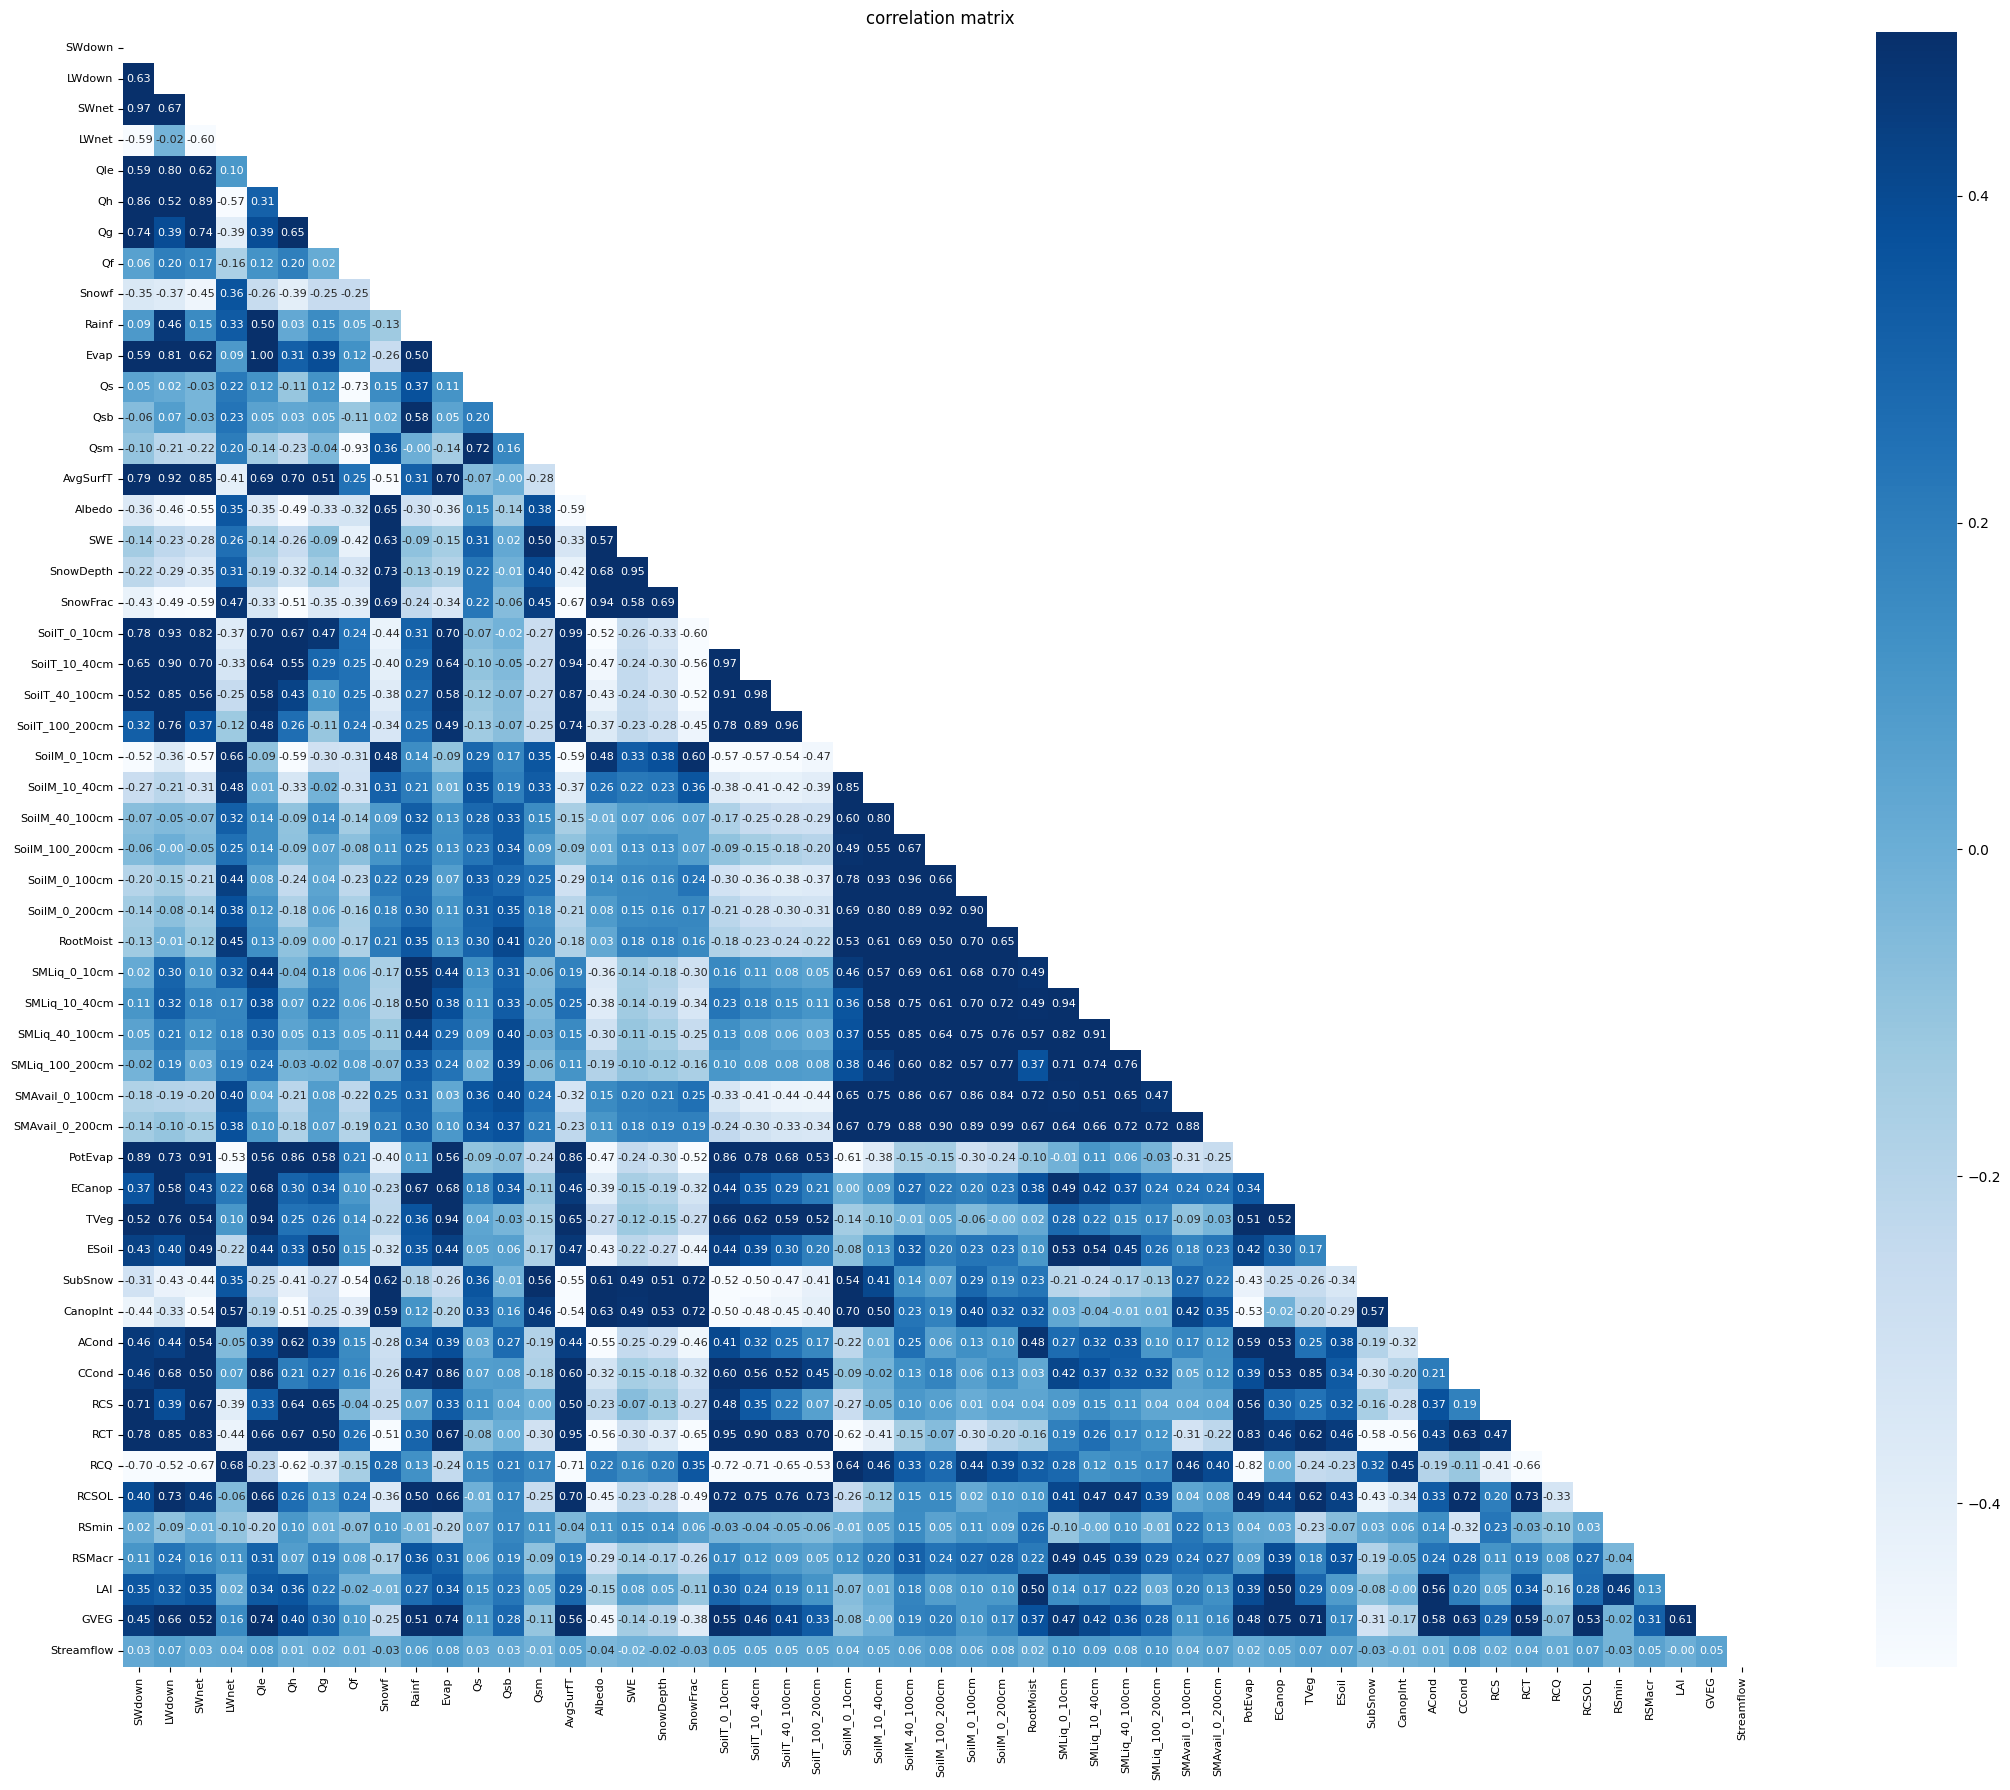

In [ ]:
# Tworzymy nasza heatmapę. Niestety funkcje pokroju sns.heatmap nie nadają się same w sobie do prezentacji tak dużych macierzy korelacji zatem potrzebne sa im pewne modyfikacje. Poniżej stowrzymy nasz wykres w taki sposób
# aby po kliknięciu na grafikę ulegała ona przybliżeniu i wyostrzeniu

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print(plt.get_backend())


corr_matrix_np[np.triu_indices_from(corr_matrix_np)] = np.nan

fig, ax = plt.subplots(figsize=(24, 18))

hm = sns.heatmap(corr_matrix_np, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 8}, annot=True,
                 square=True, cmap=plt.cm.Blues)

ticks = np.arange(corr_matrix_pd.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr_matrix_pd.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr_matrix_pd.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix')
plt.tight_layout()
plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

# Analiza korelacji

Z powyższej grafiki możemy już wysnuć pewne wnioski i wstępnie wybrać zmienne, które są skorelowane z naszą zmienną GVEG czyli wskaźnikiem zielonej roślinności.

Z pośród zmiennych, które wydają się wykazywać pewne zależności względem zmiennej GVEG mamy:


In [ ]:
#@title tabela najsilniej skorelowanych zmiennych
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Nazwa zmiennej", "Objaśnienie zmiennej", "Współczynnik korelacji"]
table.add_row(["LWdown", 'strumień promieniowania długofalowego (podczerwień) emitowanego przez atmosferę i kierowanego ku powierzchni ziemi', "0.66"])
table.add_row(["Qle", 'ilość ciepła przekazywanego w procesach, które nie pociągają za sobą zmiany temperatury, takich jak parowanie i kondensacja', "0.74"])
table.add_row(["Evap", 'Całkowita ewapotranspiracja: suma wody traconej z powierzchni ziemi do atmosfery przez parowanie i transpirację roślin', "0.74"])
table.add_row(["Ecanop", 'Parowanie wody z baldachimu: proces, w którym woda paruje bezpośrednio z powierzchni liści i innych części roślin (tzw. "korony drzew")', "0.75"])
table.add_row(["TVeg", 'Transpiracja: Proces, w którym woda jest pobierana przez korzenie roślin, przemieszcza się przez roślinę i jest uwalniana do atmosfery przez aparaty szparkowe w liściach', "0.71"])
table.add_row(["CCond", 'Przewodność baldachimu: miara zdolności liści i innych części roślin do wymiany gazów i pary wodnej z atmosferą', "0.63"])
table.add_row(["LAI", 'Wskaźnik pokrycia liściowego, indeks liściowy: stosunek całkowitej powierzchni liści roślin na jednostkę powierzchni gruntu', "0.61"])

print(table)

+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+
| Nazwa zmiennej |                                                                            Objaśnienie zmiennej                                                                           | Współczynnik korelacji |
+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+
|     LWdown     |                             strumień promieniowania długofalowego (podczerwień) emitowanego przez atmosferę i kierowanego ku powierzchni ziemi                            |          0.66          |
|      Qle       |                        ilość ciepła przekazywanego w procesach, które nie pociągają za sobą zmiany temperatury, takic